In [1]:
import numpy as np
from skimage import color, exposure, transform, io

NUM_CLASSES = 2


def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # roll color axis to color channel last style
#     img = np.rollaxis(img, 0, 3)
#     img = np.rollaxis(img, -2)
    
    return img


In [25]:
import os
from keras.preprocessing import image 
import matplotlib.pyplot as plt
%matplotlib inline 

def process_toarray(subdir):
    
    folder = '/Users/yueyingteng/Documents/IMG_hello/' + subdir + '/'
    files = os.listdir(folder)
    files = list(map(lambda x: os.path.join(folder, x), files))

    img_list = []
    for i, f in enumerate(files):
        try:
            img = image.load_img(f)
            img = img.resize((224, 224)) # keep the full size images
            img = preprocess_img(img)
            
            img = image.img_to_array(img)
            # zero mean center images 
            # img -= np.mean(img)
            
            img_list.append(img)

        except OSError:
            continue

#         if i > 5:
#             break

    img_array = np.asarray(img_list)
    
    return img_array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


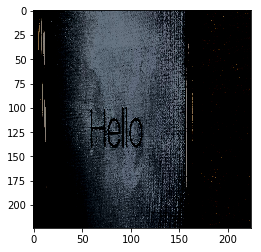

In [86]:
# file = '/Users/yueyingteng/Documents/IMG_hello/hello_all_cropped/IMG_0360_Cropped.JPG'

# img = image.load_img(file)
# img = img.resize((224, 224)) 
# img = preprocess_img(img)
# img -= np.mean(img)
# # im = image.img_to_array(img)

# plt.imshow(img)


In [62]:
# process all cropped images but keeping their original sizes 

# '/Users/yueyingteng/Documents/IMG_hello/hello_all_cropped/'

hello = process_toarray('hello_all_cropped')
no_hello = process_toarray('no_hello_all_cropped')


In [65]:
# combine the resized and histgram normalized hello nad no_hello images together then DEMEAN


print (hello.shape)
print (no_hello.shape)

# creat all x data 
x = np.concatenate((hello, no_hello))
print (x.shape)

# demean the entire traning set, hello and no_hello

print (np.mean(x)) # mean of all the training imges, which will be used in demean testing data 

def demean(x):
    x_demeaned = np.zeros((x.shape[0], IMG_HI, IMG_HI, 3))
    
    for i in range(x.shape[0]):
        x_demeaned[i] = x[i] - 0.46870396
    
    return x_demeaned

# to make the training data zero centered
x = demean(x)

# checking if demean is performed accurately 
print (np.mean(x))
x.shape


(104, 224, 224, 3)
(105, 224, 224, 3)
(209, 224, 224, 3)
0.46870396
8.673533821423983e-08


(209, 224, 224, 3)

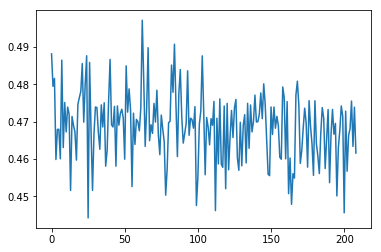

In [37]:
# means = [np.mean(x[i]) for i in range(x.shape[0])]

# plt.plot(means)

In [46]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


# hello is zero, no_hello is one 

labels = np.concatenate((np.zeros(hello.shape[0]), np.ones(no_hello.shape[0])))
# one hot encode label 

def one_hot(y):
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)

    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_y)
    
    return dummy_y

y = one_hot(labels)



In [47]:
# input images are no longer square - input_size 

# IMG_WI = hello.shape[1]
# IMG_HI = hello.shape[2]


# square images 

IMG_WI = 224
IMG_HI = 224



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
[0. 1.]


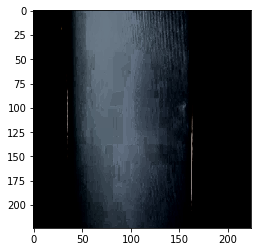

In [66]:
# visualize one image after preprocessing 

idx = 144

print(x[idx].shape)
plt.imshow(x[idx])

print (y[idx])

In [67]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
# K.set_image_data_format('channels_first')


def cnn_model():
    model = Sequential()
    
    # zero padding
    model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (IMG_WI, IMG_HI, 3), activation = 'relu'))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = 'softmax'))
    
    return model


In [68]:
from keras.optimizers import SGD

model = cnn_model()

lr = 0.01
sgd = SGD(lr = lr, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])


In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 54, 54, 64)        0         
__________

In [70]:
# train test split 

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 7)


In [71]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback,\
ReduceLROnPlateau, CSVLogger, EarlyStopping

# recuding learning rate after each epoch
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch/ 10))

csv_logger = CSVLogger('./demean_hist_norm.csv')
early_stopper = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10)

batch_size = 16
epochs = 30

history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
                   validation_data = (x_test, y_test),
                   shuffle = True,
                   callbacks = [LearningRateScheduler(lr_schedule),
                                ModelCheckpoint('model.h5', save_best_only=True), 
                                early_stopper, 
                                csv_logger])




Train on 167 samples, validate on 42 samples
Epoch 1/30
167/167 [==============================] - 65s 389ms/step - loss: 0.6437 - acc: 0.6467 - val_loss: 0.6378 - val_acc: 0.5000
Epoch 2/30
167/167 [==============================] - 65s 389ms/step - loss: 0.4920 - acc: 0.8084 - val_loss: 0.8436 - val_acc: 0.6190
Epoch 3/30
167/167 [==============================] - 60s 361ms/step - loss: 0.8162 - acc: 0.5689 - val_loss: 0.6739 - val_acc: 0.4524
Epoch 4/30
167/167 [==============================] - 58s 347ms/step - loss: 0.6448 - acc: 0.6886 - val_loss: 0.5783 - val_acc: 0.8571
Epoch 5/30
167/167 [==============================] - 64s 383ms/step - loss: 0.6232 - acc: 0.6946 - val_loss: 0.6802 - val_acc: 0.5714
Epoch 6/30
167/167 [==============================] - 68s 407ms/step - loss: 0.5659 - acc: 0.6707 - val_loss: 0.4510 - val_acc: 0.8333
Epoch 7/30
167/167 [==============================] - 68s 409ms/step - loss: 0.4339 - acc: 0.8623 - val_loss: 0.3619 - val_acc: 0.9048
Epoch 8/30

In [20]:
# # CLR training 

# from clr_callback import *

# model = cnn_model()

# lr = 0.01
# sgd = SGD(lr = lr, decay = 1e-6, momentum = 0.9, nesterov = True)

# clr_triangular = CyclicLR(base_lr = 0, max_lr = 0.01, step_size = np.ceil(x_train.shape[0] * epochs/ batch_size), mode = 'triangular')

# model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])


# history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
#                    validation_data = (x_test, y_test),
#                    shuffle = True,
#                    callbacks = [LearningRateScheduler(lr_schedule), clr_triangular,
#                                 ModelCheckpoint('model.h5', save_best_only=True), early_stopper, csv_logger])




Train on 167 samples, validate on 42 samples
Epoch 1/30
167/167 [==============================] - 65s 389ms/step - loss: 0.6892 - acc: 0.5329 - val_loss: 0.7066 - val_acc: 0.4524
Epoch 2/30
167/167 [==============================] - 60s 360ms/step - loss: 0.7807 - acc: 0.4431 - val_loss: 0.6949 - val_acc: 0.5476
Epoch 3/30
167/167 [==============================] - 60s 359ms/step - loss: 0.7250 - acc: 0.4910 - val_loss: 0.6923 - val_acc: 0.5476
Epoch 4/30
167/167 [==============================] - 62s 372ms/step - loss: 0.7119 - acc: 0.4910 - val_loss: 0.6891 - val_acc: 0.5476
Epoch 5/30
167/167 [==============================] - 61s 367ms/step - loss: 0.6975 - acc: 0.4910 - val_loss: 0.6893 - val_acc: 0.5476
Epoch 6/30
167/167 [==============================] - 61s 368ms/step - loss: 0.6952 - acc: 0.4910 - val_loss: 0.6889 - val_acc: 0.5476
Epoch 7/30
167/167 [==============================] - 67s 399ms/step - loss: 0.6977 - acc: 0.4910 - val_loss: 0.6874 - val_acc: 0.5476
Epoch 8/30

In [22]:
model.evaluate(x_test, y_test)

42/42 [==============================] - 5s 116ms/step


[0.6947178556805566, 0.45238094954263597]

In [13]:
# test on completely unseen images 


# for images in the secodn batch - same preprocessing 

# test_hello = process_toarray('second_batch_hello_all_cropped')
test_no_hello = process_toarray('keep_aside_to_balance_classes')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(42, 224, 224, 3)


0.9761904761904762

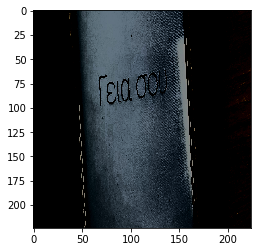

In [106]:
print (test_hello.shape)


# show one unseen image
plt.imshow(test_hello[0])

# print (test_hello[:2].shape)

# prediction all images 
pred_hello = np.argmax(model.predict(test_hello), axis = 1)
# create one hot encoded labels 
label_hello = [0] * test_hello.shape[0]
truth_hello = np.argmax(np.eye(2)[label_hello], axis = 1)


# accuracy 
sum(truth_hello == pred_hello)/test_hello.shape[0]


(25, 224, 224, 3)


0.48

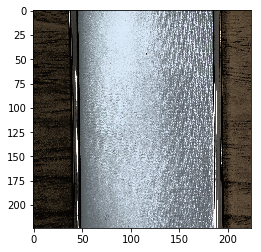

In [15]:
print (test_no_hello.shape)
# hello is zero, no_hello is ONE 

plt.imshow(test_no_hello[0])

# np.argmax(model.predict(test_no_hello[:2]), axis = 1)
# model.predict(test_no_hello[:2])
              
# prediction for all images     
pred_no_hello = np.argmax(model.predict(test_no_hello), axis = 1)
# create one hot encoded labels
truth_no_hello = [1] * test_no_hello.shape[0]

# accuracy 
sum(pred_no_hello == truth_no_hello)/ test_no_hello.shape[0]



1.0

### data augmentation 

### look at the wrongly classified images 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


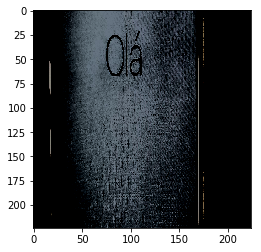

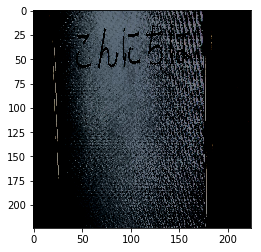

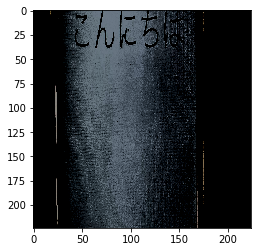

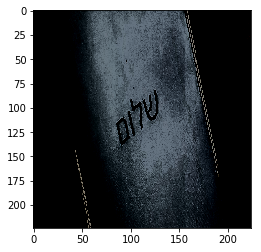

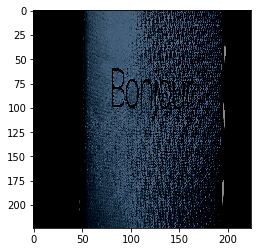

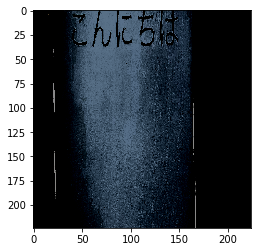

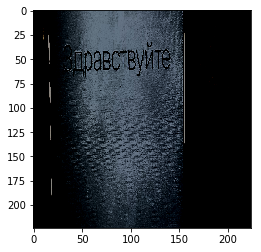

In [74]:
# hello
# gather all wrongly classified images

# create index for hello images 
test_hello_idx = np.array(range(test_hello.shape[0]))
# wrongly classfied image indices 
wrong_hello = test_hello_idx[truth_hello != pred_hello]

# print those wrongly classified images 

for i in wrong_hello:
    img = test_hello[i]
    plt.figure()
    plt.imshow(img)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


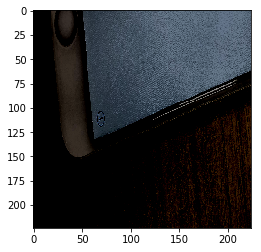

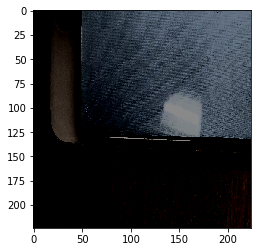

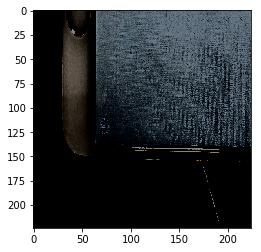

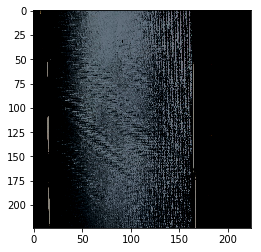

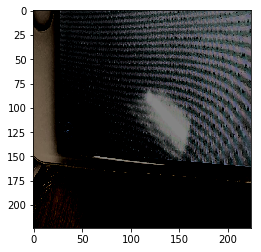

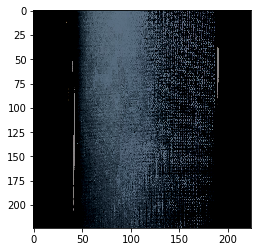

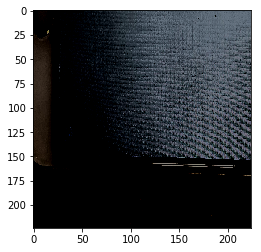

In [75]:
# no_hello
# gather all wrongly classified images

# create index for no_hello images 
test_no_hello_idx = np.array(range(test_no_hello.shape[0]))
# wrongly classfied image indices 
wrong_no_hello = test_no_hello_idx[truth_no_hello != pred_no_hello]

# print those wrongly classified images 

for i in wrong_no_hello:
    img = test_no_hello[i]
    plt.figure()
    plt.imshow(img)
    